In [1]:
!pip -q install -U langgraph langchain geopandas shapely pyproj fiona rasterio folium branca ipywidgets matplotlib pandas requests networkx

import os, sys, io, json, math, calendar, traceback
import numpy as np, pandas as pd, geopandas as gpd, requests
from io import StringIO
import matplotlib.pyplot as plt
from shapely.geometry import box, mapping
import folium
from folium.plugins import Fullscreen
from typing import TypedDict, Dict, Any, Optional, List

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import AIMessage

def try_get(url, timeout=15):
    try:
        r = requests.get(url, timeout=timeout)
        if r.status_code == 200:
            return r
    except Exception:
        pass
    return None


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2

In [2]:
# Khắc phục xung đột phiên bản trong Colab
!pip install pandas==2.2.2 requests==2.32.4 -q
import pandas as pd, requests
print("Pandas version:", pd.__version__)
print("Requests version:", requests.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.2 MB/s eta 0:00:00
Pandas version: 2.3.2
Requests version: 2.32.5


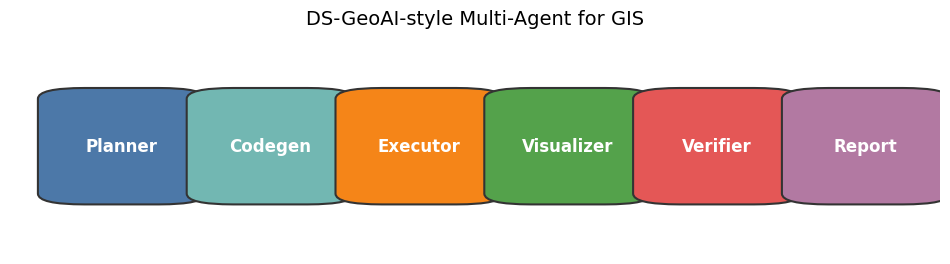

In [3]:
import matplotlib.patches as patches

def draw_solution_diagram(title="Multi-Agent GIS Pipeline"):
    fig, ax = plt.subplots(figsize=(12,2.8))
    ax.axis('off')

    steps = ["Planner", "Codegen", "Executor", "Visualizer", "Verifier", "Report"]
    colors = ["#4c78a8","#72b7b2","#f58518","#54a24b","#e45756","#b279a2"]

    x, y, w, h = 0.05, 0.25, 0.14, 0.5
    for i, s in enumerate(steps):
        rect = patches.FancyBboxPatch((x+i*(w+0.02), y), w, h,
                                      boxstyle="round,pad=0.02,rounding_size=0.05",
                                      linewidth=1.5, edgecolor="#333", facecolor=colors[i])
        ax.add_patch(rect)
        ax.text(x+i*(w+0.02)+w/2, y+h/2, s, ha="center", va="center", color="white", fontsize=12, fontweight="bold")
        if i < len(steps)-1:
            ax.annotate("", xy=(x+(i+1)*(w+0.02)-0.01, y+h/2), xytext=(x+i*(w+0.02)+w+0.01, y+h/2),
                        arrowprops=dict(arrowstyle="->", lw=1.8, color="#333"))
    ax.set_title(title, fontsize=14, pad=10)
    plt.show()

draw_solution_diagram("DS-GeoAI-style Multi-Agent for GIS")


In [4]:
class DSState(TypedDict, total=False):
    case: str
    params: Dict[str, Any]
    artifacts: Dict[str, Any]
    messages: List[Any]
    _code: Optional[str]
    _map_obj: Optional[folium.Map]
    _figs: List[Any]
    _tables: Dict[str, pd.DataFrame]
    _notes: List[str]

def router(state: DSState) -> Command[str]:
    case = (state.get("case") or "").lower()
    if case in ("france_mobility","fr","france"):
        nxt = "codegen"
    elif case in ("hazardous_nc","hazardous","hw_nc","nc"):
        nxt = "codegen"
    elif case in ("covid_us","covid","us_counties"):
        nxt = "codegen"
    else:
        nxt = "help"
    return Command(goto=nxt, update={
        "messages": state.get("messages", []) + [AIMessage(content=f"[router] case={case or 'help'}")]
    })

def help(state: DSState):
    print("Cases:")
    print("- france_mobility: Pháp + mobility 2020 → choropleth matrix, Folium map, line chart")
    print("- hazardous_nc: HW sites × NC tracts + population → choropleth + highlight")
    print("- covid_us: COVID-19 2020 × Census counties → choropleth + scatter/regression")
    return Command(goto=END, update={"messages": state.get("messages", []) + [AIMessage(content="[help] printed")]})


In [42]:
def code_template_france() -> str:
    return r'''
# === France Mobility 2020 ===
import sys
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, calendar
from shapely.geometry import box, mapping
import folium
from folium.plugins import Fullscreen, MiniMap
from io import StringIO

# Dữ liệu ranh giới
fr_url = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
try:
    france_gdf = gpd.read_file(fr_url)
    src_desc = "API France.zip"
except Exception:
    # synthetic fallback: 4 vùng vuông
    polys = [box(i*2, j*2, i*2+1.8, j*2+1.5) for i in range(2) for j in range(2)]
    france_gdf = gpd.GeoDataFrame({"GID_1":[f"FRA.{i+1}_1" for i in range(4)],
                                   "NAME_1":[f"R{i+1}" for i in range(4)]},
                                  geometry=polys, crs="EPSG:4326")
    src_desc = "synthetic 4 regions"

# Dữ liệu mobility (Twitter API) hoặc synthetic
api = "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020"
r = try_get(api, timeout=15)
if r is not None:
    mob_df = pd.read_csv(StringIO(r.text))
    if "date" in mob_df.columns:
        mob_df["date"] = pd.to_datetime(mob_df["date"], errors="coerce")
        mob_df = mob_df.dropna(subset=["date"])
        mob_df["month"] = mob_df["date"].dt.month
        mob_df = mob_df.groupby(["place","month"])["intra_movement"].sum().reset_index()
else:
    # synthetic monthly pattern
    rows = []
    np.random.seed(42)
    for pl in france_gdf["GID_1"].astype(str).tolist():
        base = np.random.randint(1000,5000)
        for m in range(1,13):
            factor = 0.8 + 0.4*np.sin((m-1)*np.pi/6)  # dùng numpy thay math
            if 3<=m<=5: factor *= 0.5
            val = int(base*factor*np.random.uniform(0.9,1.1))
            rows.append({"place": pl, "month": m, "intra_movement": val})
    mob_df = pd.DataFrame(rows)

# Pivot + change vs January
piv = mob_df.pivot(index="place", columns="month", values="intra_movement")
piv = piv.rename(columns={i: calendar.month_name[i] for i in range(1,13)})
piv = piv.fillna(0.0)
jan = piv["January"].replace(0, np.nan)
for m in range(2,13):
    mm = calendar.month_name[m]
    piv[f"{mm}_change"] = (piv[mm] / jan - 1.0) * 100.0
piv = piv.replace([np.inf,-np.inf], np.nan).fillna(0.0)
change_df = piv.reset_index()  # 'place' + *_change

fr = france_gdf.copy()
fr["GID_1"] = fr["GID_1"].astype(str)
change_df["place"] = change_df["place"].astype(str)
fr_merge = fr.merge(change_df, left_on="GID_1", right_on="place", how="inner")
if fr_merge.empty:
    fr["place"] = fr["GID_1"]
    fr_merge = fr.merge(change_df, on="place", how="inner")

# ===== 1) Ma trận 12 tháng (matplotlib) — dùng constrained_layout thay tight_layout
fr_plot = fr_merge.to_crs(epsg=3857)
vals = []
for m in range(2,13):
    col = f"{calendar.month_name[m]}_change"
    if col in fr_plot.columns:
        vals.extend(pd.to_numeric(fr_plot[col], errors="coerce").astype(float).tolist())
vmax = float(np.nanpercentile(vals, 98)) if len(vals) else 50.0
vmin = -vmax
cmap = plt.cm.coolwarm
fig, axes = plt.subplots(3,4, figsize=(20,15), constrained_layout=True); axes = axes.flatten()
for i, mth in enumerate(range(1,13)):
    ax = axes[i]
    if mth == 1:
        fr_plot.plot(ax=ax, color="lightgrey", edgecolor="white")
        ax.set_title("January (base)")
    else:
        col = f"{calendar.month_name[mth]}_change"
        fr_plot.plot(column=col, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor="white", legend=False)
        ax.set_title(f"{calendar.month_name[mth]}")
    ax.set_axis_off()
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)); sm._A = []
fig.colorbar(sm, cax=cax).set_label("Monthly change vs Jan (%)")
fig.suptitle("France mobility changes 2020", fontsize=16)
fig_path = "france_mobility_map_matrix.png"
fig.savefig(fig_path, dpi=220, bbox_inches="tight"); plt.close(fig)

# ===== 2) Line chart (mean of regions)
monthly_cols = [f"{calendar.month_name[m]}_change" for m in range(2,13)]
month_mean = fr_merge[monthly_cols].astype(float).mean(axis=0)
plt.figure(figsize=(9,5))
plt.plot(monthly_cols, month_mean.values, marker="o")
plt.xticks(rotation=45); plt.grid(True, alpha=0.3)
plt.title("France mobility — average monthly change vs Jan")
line_path = "france_mobility_line.png"
plt.savefig(line_path, dpi=200, bbox_inches="tight"); plt.close()

# ===== 3) Folium map (December) — center bằng total_bounds (không centroid) + tô sẵn màu _fill
fr_map = fr_merge.to_crs("EPSG:4326").copy()
fr_map["GID_1"] = fr_map["GID_1"].astype(str)
if "December_change" not in fr_map.columns:
    fr_map["December_change"] = 0.0

# center an toàn (không dùng centroid trên CRS địa lý)
minx, miny, maxx, maxy = fr_map.total_bounds
center_lat, center_lon = (miny+maxy)/2.0, (minx+maxx)/2.0
m = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles="CartoDB positron")
Fullscreen().add_to(m); MiniMap(toggle_display=True, minimized=True).add_to(m)

# === Thang màu robust ===
vals_dec = pd.to_numeric(fr_map["December_change"], errors="coerce")
vals_dec = vals_dec.replace([np.inf, -np.inf], np.nan)

finite = vals_dec.dropna()
if len(finite) >= 2:
    lo, hi = np.nanpercentile(finite, [2, 98])
    # nếu percentile suy biến, fallback min/max
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = float(finite.min()), float(finite.max())
else:
    lo, hi = -50.0, 50.0  # fallback hợp lý

# tuỳ chọn: cân tâm 0 khi dữ liệu có cả âm & dương
if lo < 0 and hi > 0:
    mabs = max(abs(lo), abs(hi))
    lo, hi = -mabs, mabs

# chuẩn hoá về [0,1]
den = (hi - lo) if (hi - lo) != 0 else 1e-9
norm = (vals_dec - lo) / den
norm = norm.clip(0, 1)

# rgba -> hex bằng matplotlib colormap (không dùng cm trong lambda)
def _to_hex01(x):
    r, g, b, a = plt.cm.coolwarm(float(x))
    return "#{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255))

fr_map["_fill"] = [
    "#cccccc" if pd.isna(v) else _to_hex01(n)
    for v, n in zip(vals_dec.tolist(), norm.tolist())
]

# GeoJSON chuỗi (bao gồm cột _fill)
geojson_str = fr_map.to_json()

# Layer tô màu đọc từ thuộc tính _fill (KHÔNG dùng biến ngoài)
folium.GeoJson(
    geojson_str,
    name="December change",
    style_function=lambda f: {
        "fillColor": f["properties"].get("_fill", "#cccccc"),
        "color": "white", "weight": 0.4, "fillOpacity": 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["NAME_1","GID_1","December_change"],
        aliases=["Region","GID","Δ vs Jan (%)"],
        localize=True, labels=True, sticky=False
    )
).add_to(m)

# Legend độc lập (không dùng trong lambda, chỉ để hiển thị)
from branca.colormap import LinearColormap
cm_legend = LinearColormap(["#313695","#74add1","#ffffbf","#f46d43","#a50026"], vmin=lo, vmax=hi)
cm_legend.caption = "Change vs Jan (%)"
cm_legend.add_to(m)

folium.LayerControl().add_to(m)

map_path = "france_mobility_dec2020.html"; m.save(map_path)

# ===== Tables & artifacts
table_regions = fr_merge[["NAME_1","GID_1"]+monthly_cols].copy()
metrics = pd.DataFrame({
    "metric": ["min_change","max_change","mean_december"],
    "value": [float(np.nanmin(month_mean)), float(np.nanmax(month_mean)), float(np.nanmean(vals_dec))]
})

ARTIFACTS = {
    "src_desc": src_desc,
    "map_html": map_path,
    "matrix_png": fig_path,
    "line_png": line_path,
    "env": {"python": sys.version.split()[0], "geopandas": gpd.__version__, "folium": folium.__version__}
}
TABLES = {"regions_monthly_change": table_regions, "summary_metrics": metrics}
MAP_OBJ = m
FIGS = []
NOTES = ["Expected dip in Apr–May (COVID) vs Jan baseline."]
'''


In [22]:
def code_template_hazardous() -> str:
    return r'''
# === Hazardous Waste × NC tracts ===
import sys
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
import folium
from folium.plugins import Fullscreen, MiniMap

hw_url = "https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip"
tr_url = "https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip"
pop_url = "https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv"

hw = gpd.read_file(hw_url).to_crs("EPSG:4326")
tr = gpd.read_file(tr_url).to_crs("EPSG:4326")
pop = pd.read_csv(pop_url, dtype={"GEOID": str})
tr["GEOID"] = tr["GEOID"].astype(str)
tr = tr.merge(pop, on="GEOID", how="left").dropna(subset=["TotalPopulation"])
hits = gpd.sjoin(tr, hw, how="inner", predicate="intersects").drop_duplicates(subset=["GEOID"])

# ===== Map — center bằng total_bounds
minx, miny, maxx, maxy = tr.total_bounds
center_lat, center_lon = (miny+maxy)/2.0, (minx+maxx)/2.0
m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles="CartoDB positron")
Fullscreen().add_to(m); MiniMap(toggle_display=True, minimized=True).add_to(m)

folium.Choropleth(
    geo_data=tr.__geo_interface__, name="Total Population",
    data=tr[["GEOID","TotalPopulation"]], columns=["GEOID","TotalPopulation"],
    key_on="feature.properties.GEOID",
    fill_color="Blues", fill_opacity=0.7, line_opacity=0.2,
    legend_name="Total Population"
).add_to(m)

folium.GeoJson(
    hits.__geo_interface__, name="Tracts with Hazardous Waste",
    style_function=lambda f: {"color":"red","fillColor":"none","weight":2},
    tooltip=folium.GeoJsonTooltip(fields=["GEOID"], aliases=["GEOID:"], sticky=False)
).add_to(m)

folium.LayerControl().add_to(m)
map_path = "nc_hazardous_map.html"; m.save(map_path)

# ===== Simple chart: population histogram
plt.figure(figsize=(8,4))
tr["TotalPopulation"].plot(kind="hist", bins=30, alpha=0.7)
plt.title("Distribution of Tract Population (NC)")
plt.xlabel("Population"); plt.ylabel("Frequency")
hist_path = "nc_population_hist.png"
plt.savefig(hist_path, dpi=160, bbox_inches="tight"); plt.close()

# ===== Tables
table_hits = hits[["GEOID"]].copy()
table_pop_top = tr[["GEOID","TotalPopulation"]].sort_values("TotalPopulation", ascending=False).head(10)
metrics = pd.DataFrame({"metric":["num_hw_tracts","num_tracts"],
                        "value":[int(len(hits)), int(len(tr))]})

ARTIFACTS = {"map_html": map_path, "hist_png": hist_path,
             "env": {"python": sys.version.split()[0], "geopandas": gpd.__version__, "folium": folium.__version__}}
TABLES = {"hw_hits": table_hits, "top10_population": table_pop_top, "summary_metrics": metrics}
MAP_OBJ = m
FIGS = []
NOTES = ["HW tracts highlighted in red."]
'''


In [23]:
def code_template_covid() -> str:
    return r'''
# === COVID-19 2020 × US counties ===
import sys
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
import folium
from folium.plugins import Fullscreen, MiniMap
from scipy import stats

covid_url = "https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv"
cnty_url  = "https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip"
cen_url   = "https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv"

covid = pd.read_csv(covid_url)
covid["date"] = pd.to_datetime(covid["date"], errors="coerce")
latest = covid[covid["date"]=="2020-12-31"].dropna(subset=["fips"]).copy()
latest["fips"] = latest["fips"].astype(int).astype(str).str.zfill(5)
cnty = gpd.read_file(cnty_url); cnty["GEOID"] = cnty["GEOID"].astype(str).str.zfill(5)
cen  = pd.read_csv(cen_url);  cen["FIPS"]  = cen["FIPS"].astype(str).str.zfill(5)

latest["death_rate"] = latest.apply(lambda r:(r["deaths"]/r["cases"]*100) if r["cases"]>0 else 0, axis=1)

sen_cols = [c for c in ["Total Population: 65 to 74 Years","Total Population: 75 to 84 Years","Total Population: 85 Years and Over"] if c in cen.columns]
def _to_float(s):
    try:
        return float(str(s).replace(",",""))
    except Exception:
        return np.nan
for _c in ["Total Population"] + sen_cols:
    if _c in cen.columns:
        cen[_c] = cen[_c].map(_to_float)

cen["senior_population"] = cen[sen_cols].sum(axis=1)
cen["senior_rate"] = (cen["senior_population"]/cen["Total Population"]*100).replace([np.inf,-np.inf],0).fillna(0)

merged    = latest.merge(cen, left_on="fips", right_on="FIPS", how="inner")
cnty_full = cnty.merge(merged, left_on="GEOID", right_on="fips", how="inner")

# ===== Scatter + regression
x = pd.to_numeric(cnty_full["senior_rate"], errors="coerce").astype(float).values
y = pd.to_numeric(cnty_full["death_rate"], errors="coerce").astype(float).values
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
xp = np.array([np.nanmin(x), np.nanmax(x)]); yp = slope*xp + intercept
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.4, label="counties")
plt.plot(xp, yp, "r", label=f"fit (r²={r_value**2:.3f}, p={p_value:.4f})")
plt.xlabel("Senior rate (%)"); plt.ylabel("COVID-19 Death rate (%)")
plt.title("County-level: Seniors vs COVID-19 Death Rate (2020)")
plt.grid(True, alpha=0.3); plt.legend()
scatter_path = "covid_senior_scatter.png"
plt.savefig(scatter_path, dpi=220, bbox_inches="tight"); plt.close()

# ===== Map — làm sạch datetime/kiểu số cho Folium; center bằng total_bounds
d = cnty_full.to_crs("EPSG:4326").copy()
d["GEOID"] = d["GEOID"].astype(str)

# a) datetime -> chuỗi
for c in d.select_dtypes(include=["datetime64[ns]", "datetimetz"]).columns:
    d[c] = d[c].dt.strftime("%Y-%m-%d")

# b) numeric numpy -> float thuần
num_like = d.select_dtypes(include=["float64","float32","int64","int32","uint8","uint16","uint32","uint64"]).columns
for c in num_like:
    d[c] = pd.to_numeric(d[c], errors="coerce").astype(float)

# c) bỏ cột không dùng để tránh payload lớn
drop_cols = [c for c in ["date"] if c in d.columns]
d_vis = d.drop(columns=drop_cols) if drop_cols else d

# center an toàn
minx, miny, maxx, maxy = d_vis.total_bounds
center_lat, center_lon = (miny+maxy)/2.0, (minx+maxx)/2.0
m = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles="CartoDB positron")
Fullscreen().add_to(m); MiniMap(toggle_display=True, minimized=True).add_to(m)

chorodata = d_vis[["GEOID","death_rate"]].copy()
folium.Choropleth(
    geo_data=d_vis.to_json(),
    data=chorodata, columns=["GEOID","death_rate"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrRd", fill_opacity=0.7, line_opacity=0.2,
    legend_name="COVID-19 Death rate (%)"
).add_to(m)

tooltip_fields = [c for c in ["NAME","GEOID","cases","deaths","death_rate","senior_rate"] if c in d_vis.columns]
tooltip_alias  = ["County","FIPS","Cases","Deaths","Death rate (%)","Senior rate (%)"][:len(tooltip_fields)]
folium.GeoJson(
    d_vis.to_json(),
    name="Labels",
    tooltip=folium.GeoJsonTooltip(fields=tooltip_fields, aliases=tooltip_alias, localize=True, labels=True, sticky=False)
).add_to(m)

folium.LayerControl().add_to(m)
map_path = "covid_death_rate_map.html"; m.save(map_path)

# ===== Tables & metrics
metrics = pd.DataFrame({"metric":["r2","pvalue","num_counties"],
                        "value":[float(r_value**2), float(p_value), int(len(d_vis))]})
top10 = d_vis[["GEOID","death_rate"]].sort_values("death_rate", ascending=False).head(10)

ARTIFACTS = {"map_html": map_path, "scatter_png": scatter_path,
             "r2": float(r_value**2), "p": float(p_value),
             "env": {"python": sys.version.split()[0], "geopandas": gpd.__version__, "folium": folium.__version__}}
TABLES = {"top10_death_rate": top10, "summary_metrics": metrics}
MAP_OBJ = m
FIGS = []
NOTES = [f"Correlation seniors→death: R²={float(r_value**2):.3f}, p={float(p_value):.4f}"]
'''


In [37]:
def _run_generated(code: str) -> Dict[str, Any]:
    # sandbox globals
    glb = {"np":np, "pd":pd, "gpd":gpd, "plt":plt, "folium":folium, "Fullscreen":Fullscreen,
           "box":box, "mapping":mapping, "calendar":calendar, "try_get":try_get, "StringIO":StringIO}
    loc = {}
    exec(code, glb, loc)
    out = {
        "ARTIFACTS": loc.get("ARTIFACTS", {}),
        "TABLES": loc.get("TABLES", {}),
        "MAP_OBJ": loc.get("MAP_OBJ", None),
        "FIGS": loc.get("FIGS", []),
        "NOTES": loc.get("NOTES", [])
    }
    return out

def executor(state: DSState) -> Command[str]:
    try:
        out = _run_generated(state["_code"])
    except Exception as e:
        print("[executor] error:", e)
        print(traceback.format_exc())
        out = {"ARTIFACTS":{}, "TABLES":{}, "MAP_OBJ":None, "FIGS":[], "NOTES":[f"error: {e}"]}

    return Command(goto="visualizer", update={
        "artifacts": out["ARTIFACTS"],
        "_tables": out["TABLES"],
        "_map_obj": out["MAP_OBJ"],
        "_figs": out["FIGS"],
        "_notes": out["NOTES"],
        "messages": state.get("messages", []) + [AIMessage(content="[executor] done")]
    })

from IPython.display import display, HTML

def visualizer(state: DSState) -> Command[str]:
    print("=== INTERACTIVE MAP ===")
    if state.get("_map_obj") is not None:
        display(state["_map_obj"])
    else:
        print("(no map)")
    print("\n=== FIGURES ===")
    figs = state.get("_figs") or []
    for f in figs:
        try: display(f)
        except: pass
    return Command(goto="verifier", update={"messages": state.get("messages", [])})

def verifier(state: DSState) -> Command[str]:
    case = (state.get("case") or "").lower()
    arts = state.get("artifacts", {})
    notes = state.get("_notes", [])[:]
    if "france" in case:
        notes.append("Check: Apr–May drop vs Jan in line chart & matrix.")
    if "hazardous" in case:
        notes.append("Check: red-outlined tracts are HW intersects; review counts in summary table.")
    if "covid" in case:
        r2 = arts.get("r2"); p = arts.get("p")
        if r2 is not None and p is not None:
            notes.append(f"R²={r2:.3f}, p={p:.4f} (expect positive correlation).")
    return Command(goto="report", update={"_notes": notes, "messages": state.get("messages", []) + [AIMessage(content="[verifier] notes ready")]})

def report(state: DSState):
    print("=== REPORT ===")
    for k,v in (state.get("artifacts") or {}).items():
        print("-", k, ":", v)
    print("\n=== TABLES ===")
    for name, df in (state.get("_tables") or {}).items():
        print(f"▼ {name} (shape={df.shape})")
        display(df.head(10))
    print("\n=== NOTES ===")
    for n in (state.get("_notes") or []):
        print("-", n)
    return Command(goto=END, update={"messages": state.get("messages", []) + [AIMessage(content="[report] done")]})


In [35]:
g = StateGraph(DSState)
g.add_node("router", router)
g.add_node("help",   help)
g.add_node("codegen", codegen)
g.add_node("executor", executor)
g.add_node("visualizer", visualizer)
g.add_node("verifier",  verifier)
g.add_node("report",    report)
g.add_edge(START, "router")
graph = g.compile()
print("Graph compiled ✅")


Graph compiled ✅


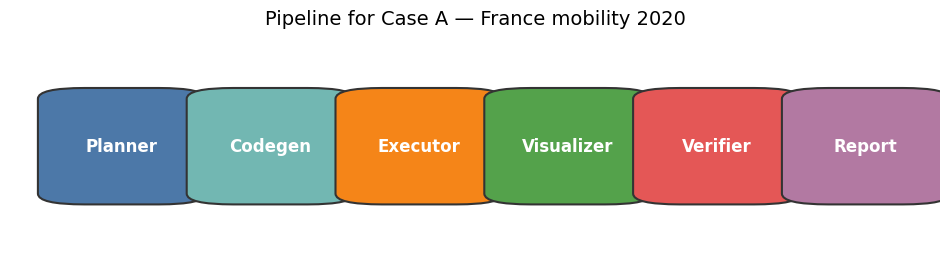

=== GENERATED CODE (snippet) ===

# === France Mobility 2020 ===
import sys
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, calendar
from shapely.geometry import box, mapping
import folium
from folium.plugins import Fullscreen, MiniMap
from io import StringIO

# Dữ liệu ranh giới
fr_url = "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip"
try:
    france_gdf = gpd.read_file(fr_url)
    src_desc = "API France.zip"
except Exception:
    # synthetic fallback: 4 vùng vuông
    polys = [box(i*2, j*2, i*2+1.8, j*2+1.5) for i in range(2) for j in range(2)]
    france_gdf = gpd.GeoDataFrame({"GID_1":[f"FRA.{i+1}_1" for i in range(4)],
                                   "NAME_1":[f"R{i+1}" for i in range(4)]},
                                  geometry=polys, crs="EPSG:4326") 
... (truncated) ...

=== INTERACTIVE MAP ===



=== FIGURES ===
=== REPORT ===
- src_desc : API France.zip
- map_html : france_mobility_dec2020.html
- matrix_png : france_mobility_map_matrix.png
- line_png : france_mobility_line.png
- env : {'python': '3.12.11', 'geopandas': '1.1.1', 'folium': '0.20.0'}

=== TABLES ===
▼ regions_monthly_change (shape=(13, 13))


,NAME_1,GID_1,February_change,March_change,April_change,May_change,June_change,July_change,August_change,September_change,October_change,November_change,December_change
0,Auvergne-Rhône-Alpes,FRA.1_1,10.517388,-28.583545,-27.848459,-33.107153,8.566582,-6.389596,-31.552163,-50.296862,-51.399491,-51.229856,-26.067289
1,Bourgogne-Franche-Comté,FRA.2_1,24.194025,-28.778468,-23.543330,-23.602484,30.819284,1.685892,-18.633540,-44.188110,-49.157054,-41.467022,-21.118012
2,Bretagne,FRA.3_1,19.267255,-23.225384,-27.216225,-24.959110,26.529277,-3.271181,-33.856722,-39.712136,-50.539745,-45.894668,-33.824010
3,Centre-Val de Loire,FRA.4_1,19.101467,-36.124694,-27.750611,-37.347188,30.409535,-8.221271,-25.336186,-47.371638,-51.589242,-44.804401,-32.243276
4,Corse,FRA.5_1,15.818432,-34.319120,-23.796424,-29.917469,12.929849,-5.089409,-29.504814,-42.022008,-50.000000,-44.291609,-29.229711
5,Grand Est,FRA.6_1,23.076923,-25.593098,-28.324946,-21.782890,17.757009,13.012221,-18.547807,-45.147376,-53.630482,-37.958303,-19.554277
6,Hauts-de-France,FRA.7_1,20.674551,-26.500219,-26.982041,-26.675427,26.412615,-6.438896,-34.866404,-47.787998,-51.160753,-44.634253,-27.814279
7,Île-de-France,FRA.8_1,15.375154,-38.560886,-27.429274,-30.043050,17.435424,-2.183272,-30.504305,-47.140221,-54.274293,-52.398524,-35.854859
8,Normandie,FRA.9_1,15.286783,-32.768080,-27.780549,-38.379052,18.279302,-6.583541,-34.613466,-42.793017,-52.743142,-45.411471,-25.211970
9,Nouvelle-Aquitaine,FRA.10_1,20.871487,-27.502368,-25.071045,-36.754026,26.965583,-5.083675,-25.039470,-42.374487,-54.625829,-50.773603,-33.217556


▼ summary_metrics (shape=(3, 2))


,metric,value
0,min_change,-51.436298
1,max_change,22.366805
2,mean_december,-26.921202



=== NOTES ===
- Expected dip in Apr–May (COVID) vs Jan baseline.
- Check: Apr–May drop vs Jan in line chart & matrix.
- [router] case=france_mobility
- [codegen] ready
- [executor] done
- [verifier] notes ready
- [report] done

Artifacts: {'src_desc': 'API France.zip', 'map_html': 'france_mobility_dec2020.html', 'matrix_png': 'france_mobility_map_matrix.png', 'line_png': 'france_mobility_line.png', 'env': {'python': '3.12.11', 'geopandas': '1.1.1', 'folium': '0.20.0'}}


In [43]:
draw_solution_diagram("Pipeline for Case A — France mobility 2020")

state_fr = graph.invoke({"case":"france_mobility","params":{},"messages":[]})
for m in state_fr["messages"]:
    if isinstance(m, AIMessage): print("-", m.content)
print("\nArtifacts:", state_fr.get("artifacts"))


In [19]:
draw_solution_diagram("Pipeline for Case B — Hazardous NC")

state_nc = graph.invoke({"case":"hazardous_nc","params":{},"messages":[]})
for m in state_nc["messages"]:
    if isinstance(m, AIMessage): print("-", m.content)
print("\nArtifacts:", state_nc.get("artifacts"))


Output hidden; open in https://colab.research.google.com to view.

In [41]:
draw_solution_diagram("Pipeline for Case C — COVID-19 counties (US)")

state_covid = graph.invoke({"case":"covid_us","params":{},"messages":[]})
for m in state_covid["messages"]:
    if isinstance(m, AIMessage): print("-", m.content)
print("\nArtifacts:", state_covid.get("artifacts"))


Output hidden; open in https://colab.research.google.com to view.

Support for third party widgets will remain active for the duration of the session. To disable support: